In [1]:
!python3 --version

Python 3.10.12


In [2]:
!update-alternatives --install /usr/bin/python python /usr/bin/python3.8

update-alternatives: --install needs <link> <name> <path> <priority>

Use 'update-alternatives --help' for program usage information.


In [3]:
!update-alternatives --list python

update-alternatives: error: no alternatives for python


In [4]:
!sudo update-alternatives --config python
## !Set python3.8 as default.

update-alternatives: error: no alternatives for python


In [5]:
!sudo update-alternatives --set python /usr/bin/python3.8

update-alternatives: error: no alternatives for python


In [7]:
#Installing Tensorflow
!pip install tensorflow==2.12.0
import tensorflow as tf
print(tf.__version__)

2.12.0


In [8]:
#More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [9]:
from google.colab import files
uploaded = files.upload()

Saving nifty.csv to nifty.csv


In [10]:
import io
df = pd.read_csv(io.BytesIO(uploaded['nifty.csv']))

In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-01,5200.899902,5310.850098,5167.100098,5263.100098,5263.100098,0
1,2010-01-08,5264.250000,5300.500000,5169.549805,5259.899902,5259.899902,0
2,2010-01-15,5259.899902,5292.500000,5085.450195,5094.149902,5094.149902,0
3,2010-01-22,5094.149902,5094.149902,4824.950195,4867.250000,4867.250000,0
4,2010-01-29,4866.149902,4951.149902,4766.000000,4845.350098,4845.350098,0


In [12]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
604,2021-07-30,15800.599609,16349.450195,15744.849609,16294.599609,16294.599609,1831600
605,2021-08-06,16304.400391,16375.500000,16162.549805,16364.400391,16364.400391,1406700
606,2021-08-13,16385.699219,16701.849609,16376.299805,16568.849609,16568.849609,1125100
607,2021-08-20,16382.500000,16712.449219,16376.049805,16636.900391,16636.900391,1421200
608,2021-08-27,16642.550781,17153.500000,16565.599609,17132.199219,17132.199219,965300


In [13]:
#Normalizing the data
# Lets work with the close data
series = df['Close'].values.reshape(-1,1)
scalar = StandardScaler()
scalar.fit(series[:len(series) // 2])
series = scalar.transform(series).flatten()

In [14]:
#building the dataset
#checking if T past values can be used to predict the next future value
T = 10
D = 1
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1) #This will make the data of the form N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (599, 10, 1) Y.shape (599,)


In [15]:
#Trying out Autoregressive RNN Model
i = Input(shape=(T,1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer = Adam(lr=0.1),
)

#Training the RNN
r = model.fit(
    X[:-N//2],Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
10/10 [==============================] - 4s 96ms/step - loss: 1.6255 - val_loss: 21.9600
Epoch 2/80
10/10 [==============================] - 0s 22ms/step - loss: 1.5558 - val_loss: 21.4900
Epoch 3/80
10/10 [==============================] - 0s 19ms/step - loss: 1.4970 - val_loss: 21.0516
Epoch 4/80
10/10 [==============================] - 0s 20ms/step - loss: 1.4442 - val_loss: 20.6481
Epoch 5/80
10/10 [==============================] - 0s 22ms/step - loss: 1.3962 - val_loss: 20.2712
Epoch 6/80
10/10 [==============================] - 0s 18ms/step - loss: 1.3526 - val_loss: 19.9099
Epoch 7/80
10/10 [==============================] - 0s 18ms/step - loss: 1.3085 - val_loss: 19.5572
Epoch 8/80
10/10 [==============================] - 0s 18ms/step - loss: 1.2685 - val_loss: 19.1441
Epoch 9/80
10/10 [==============================] - 0s 18ms/step - loss: 1.2252 - val_loss: 18.7387
Epoch 10/80
10/10 [==============================] - 0s 20ms/step - loss: 1.1820 - val_loss: 18.3250

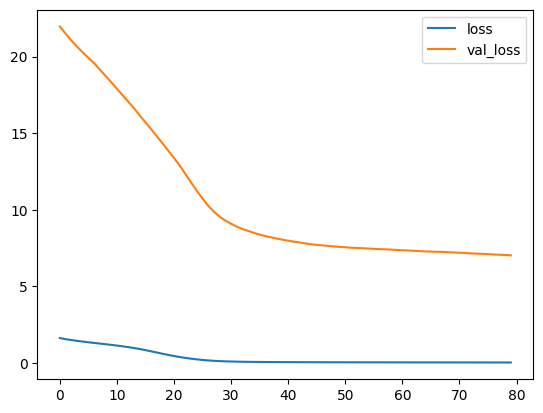

In [16]:
#Plotting loss per iteration
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

19/19 [==============================] - 1s 2ms/step
(599, 1)


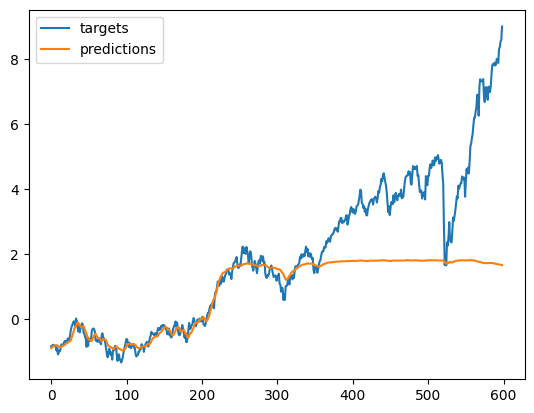

In [17]:
#1-step forecasting using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label = 'targets')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.show()


1/1 [==============================] - 0s 40ms/step


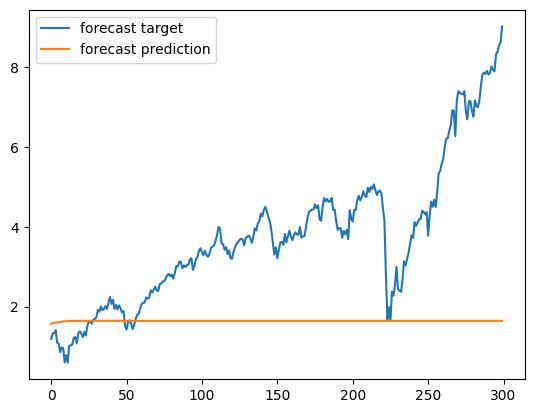

In [18]:
#Multistep forecasting using true targets
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] # 1 dimensional array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T,1))[0,0] #giving a 1x1 array or a scalar

  #updating the list of predictions
  validation_predictions.append(p)

  #making new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediction')
plt.legend()

In [19]:
#calculating returns
df['PrevClose'] = df['Close'].shift(1)
df['Return'] = (df['Close'] - df['PrevClose'])/ df['PrevClose']

In [20]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PrevClose,Return
0,2010-01-01,5200.899902,5310.850098,5167.100098,5263.100098,5263.100098,0,NaN,NaN
1,2010-01-08,5264.250000,5300.500000,5169.549805,5259.899902,5259.899902,0,5263.100098,-0.000608
2,2010-01-15,5259.899902,5292.500000,5085.450195,5094.149902,5094.149902,0,5259.899902,-0.031512
3,2010-01-22,5094.149902,5094.149902,4824.950195,4867.250000,4867.250000,0,5094.149902,-0.044541
4,2010-01-29,4866.149902,4951.149902,4766.000000,4845.350098,4845.350098,0,4867.250000,-0.004499


In [21]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,PrevClose,Return
604,2021-07-30,15800.599609,16349.450195,15744.849609,16294.599609,16294.599609,1831600,15778.450195,0.032712
605,2021-08-06,16304.400391,16375.500000,16162.549805,16364.400391,16364.400391,1406700,16294.599609,0.004284
606,2021-08-13,16385.699219,16701.849609,16376.299805,16568.849609,16568.849609,1125100,16364.400391,0.012494
607,2021-08-20,16382.500000,16712.449219,16376.049805,16636.900391,16636.900391,1421200,16568.849609,0.004107
608,2021-08-27,16642.550781,17153.500000,16565.599609,17132.199219,17132.199219,965300,16636.900391,0.029771


<Axes: >

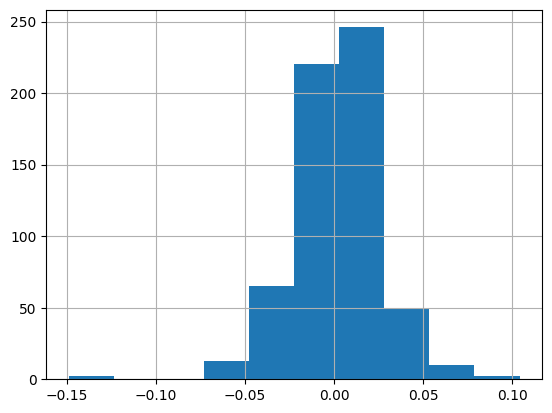

In [22]:
# Plotting the returns
df['Return'].hist()

In [23]:
# Normalizing the data
series = df['Return'].values[1:].reshape(-1,1)
scalar = StandardScaler()
scalar.fit(series[:len(series)//2])
series = scalar.transform(series).flatten()

In [24]:
# Building the dataset
#Lets try predicting the future stock price using T past values
T = 10
D = 1
X = []
Y = []
for t in range(len(series) -T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)  #This will make the data of the form N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (598, 10, 1) Y.shape (598,)


In [25]:
#Trying out Autoregressive RNN Model
i = Input(shape=(T,1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer = Adam(lr=0.01),
)

#Training the RNN
r = model.fit(
    X[:-N//2],Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
10/10 [==============================] - 3s 69ms/step - loss: 0.9793 - val_loss: 1.1133
Epoch 2/80
10/10 [==============================] - 0s 13ms/step - loss: 0.9779 - val_loss: 1.1147
Epoch 3/80
10/10 [==============================] - 0s 25ms/step - loss: 0.9772 - val_loss: 1.1163
Epoch 4/80
10/10 [==============================] - 0s 21ms/step - loss: 0.9766 - val_loss: 1.1165
Epoch 5/80
10/10 [==============================] - 0s 19ms/step - loss: 0.9758 - val_loss: 1.1177
Epoch 6/80
10/10 [==============================] - 0s 19ms/step - loss: 0.9748 - val_loss: 1.1195
Epoch 7/80
10/10 [==============================] - 0s 18ms/step - loss: 0.9741 - val_loss: 1.1215
Epoch 8/80
10/10 [==============================] - 0s 22ms/step - loss: 0.9733 - val_loss: 1.1239
Epoch 9/80
10/10 [==============================] - 0s 20ms/step - loss: 0.9731 - val_loss: 1.1260
Epoch 10/80
10/10 [==============================] - 0s 18ms/step - loss: 0.9720 - val_loss: 1.1255
Epoch 11/

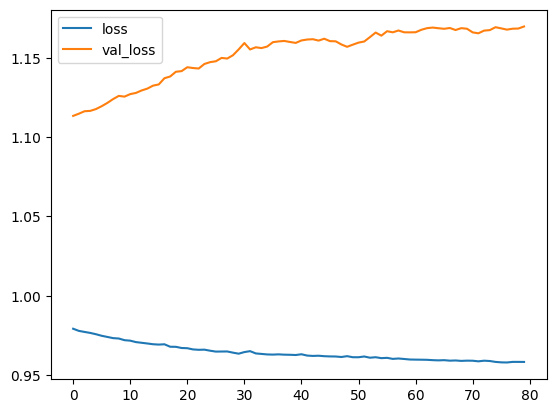

In [26]:
#Plotting loss per iteration
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

19/19 [==============================] - 1s 3ms/step
(598, 1)


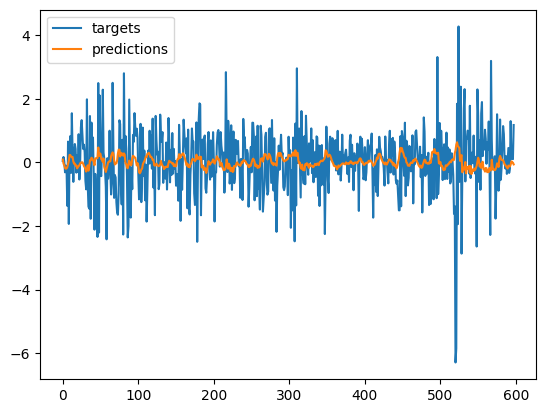

In [27]:
#1-step forecasting using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label = 'targets')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 59ms/step


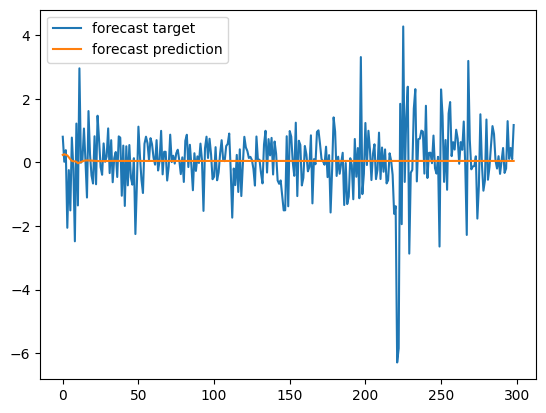

In [28]:
#Multistep forecasting using true targets
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] # 1 dimensional array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T,1))[0,0] #giving a 1x1 array or a scalar

  #updating the list of predictions
  validation_predictions.append(p)

  #making new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediction')
plt.legend()

In [29]:
# Converting full data into numpy arrays
input_data = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
targets = df['Return'].values

In [30]:
# Preparing the data for neural network
T = 10
D = input_data.shape[1]
N = len(input_data)-T

In [31]:
# Normalizing the data
Ntrain = len(input_data)*2//3
scalar = StandardScaler()
scalar.fit(input_data[:Ntrain +T])
input_data = scalar.transform(input_data)

In [32]:
# Setting up X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (targets[t+T]>0)

In [33]:
# Setting up X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N-Ntrain):
  # u counts from 0 to (N - Ntrain) while t counts from Ntrain till N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T]>0)

In [34]:
# Making the RNN
i = Input(shape=(T,D))
x = LSTM(50)(i)
x = Dense(1, activation = 'sigmoid')(x)
model = Model(i,x)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(lr = 0.01),
    metrics = ['accuracy'],
)

In [35]:
# Taining the RNN
r = model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs= 300,
    validation_data = (X_test, Y_test),
)

Epoch 1/300
13/13 [==============================] - 3s 70ms/step - loss: 0.6932 - accuracy: 0.5123 - val_loss: 0.6927 - val_accuracy: 0.5130
Epoch 2/300
13/13 [==============================] - 0s 15ms/step - loss: 0.6828 - accuracy: 0.5764 - val_loss: 0.6938 - val_accuracy: 0.5751
Epoch 3/300
13/13 [==============================] - 0s 14ms/step - loss: 0.6827 - accuracy: 0.5616 - val_loss: 0.6963 - val_accuracy: 0.5699
Epoch 4/300
13/13 [==============================] - 0s 14ms/step - loss: 0.6800 - accuracy: 0.5714 - val_loss: 0.6862 - val_accuracy: 0.5855
Epoch 5/300
13/13 [==============================] - 0s 13ms/step - loss: 0.6780 - accuracy: 0.5739 - val_loss: 0.6849 - val_accuracy: 0.5855
Epoch 6/300
13/13 [==============================] - 0s 13ms/step - loss: 0.6779 - accuracy: 0.5739 - val_loss: 0.6850 - val_accuracy: 0.5803
Epoch 7/300
13/13 [==============================] - 0s 15ms/step - loss: 0.6772 - accuracy: 0.5739 - val_loss: 0.6885 - val_accuracy: 0.5699
Epoch 

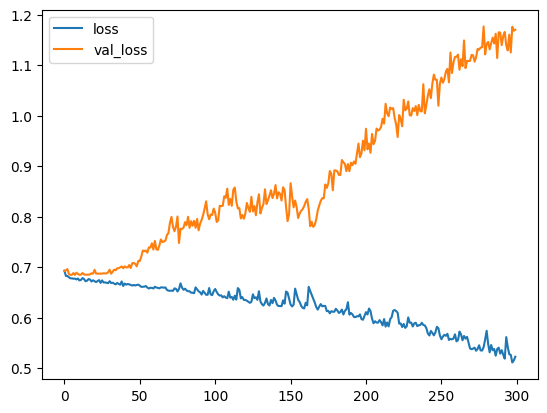

In [36]:
# plotting the Loss
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

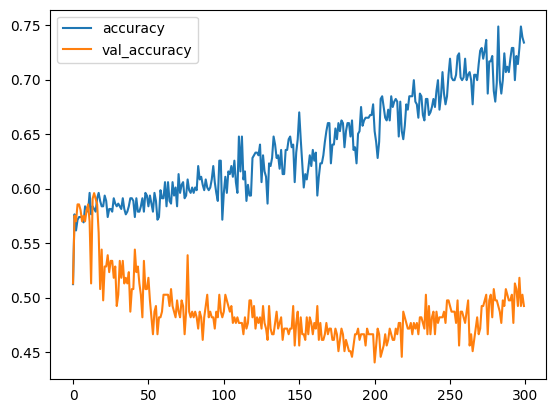

In [37]:
# Plotting Accuracy for every iteration
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()